## connect drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!mkdir otwwizzudah-bismillahversion

mkdir: cannot create directory ‘otwwizzudah-bismillahversion’: File exists


In [ ]:
%cd otwwizzudah-bismillahversion

/content/drive/MyDrive/otwwizzudah-bismillahversion


In [ ]:
!mkdir lstmversion

mkdir: cannot create directory ‘lstmversion’: File exists


In [ ]:
%cd lstmversion

/content/drive/MyDrive/otwwizzudah-bismillahversion/lstmversion


## download and import library

In [ ]:
!pip install keras

In [ ]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, LSTM
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.models import Model
from sklearn.model_selection import train_test_split
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import matplotlib.pyplot as plt
import pickle
import csv
import requests
from io import StringIO
import torch.nn as nn
import torch
import tensorflow as tf

## dataset

In [ ]:
data = pd.read_csv('dataset.csv')
data

,Question,Tag,Label
0,Selamat pagi,Salam Pembuka,Salam
1,Halo,Salam Pembuka,Salam
2,Assalamualaikum,Salam Pembuka,Salam
3,Salam sejahtera,Salam Pembuka,Salam
4,Selamat siang,Salam Pembuka,Salam
...,...,...,...
855,Terima kasih atas bantuannya.,Salam Penutup,Salam
856,"Baiklah, saya akan mencoba memahami informasi ...",Salam Penutup,Salam
857,Saya sangat menghargai bantuan Anda. Sampai ju...,Salam Penutup,Salam
858,"Baiklah, saya akan mencatat informasi yang tel...",Salam Penutup,Salam


In [ ]:
isi = data.Question.values
isi.shape
isi

array(['Selamat pagi', 'Halo', 'Assalamualaikum', 'Salam sejahtera',
       'Selamat siang', 'Selamat sore', 'Selamat malam', 'Hai', 'Yo',
       'Hei', 'Permisi', 'Misi', 'cs puri surya jaya bukan?',
       'bisa tanya?', 'benar dengan customer service puri surya jaya?',
       'halo selamat pagi', 'halo selamat siang', 'halo selamat sore',
       'halo selamat malam', 'Hai selamat pagi', 'Hai selamat siang',
       'Hai selamat sore', 'Hai selamat malam',
       'Apakah fasilitas umum boleh dimanfaatkan untuk pembuatan rumah ibadah? ',
       'Apakah dimungkinkan untuk menggunakan fasilitas umum dalam proses pembangunan rumah ibadah?',
       'Bisakah infrastruktur publik dimanfaatkan dalam pembuatan tempat ibadah?',
       'Apakah izin menggunakan fasilitas umum dapat diberikan untuk pembangunan rumah ibadah?',
       'Apakah ada regulasi yang mengizinkan pemanfaatan fasilitas umum untuk pembangunan rumah ibadah?',
       'Apakah Cluster Puri Surya Jaya memiliki kebijakan terkait pe

In [ ]:
tag = data.Tag.values
tag

array(['Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Salam Pembuka', 'Salam Pembuka', 'Salam Pembuka',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Fasilitas umum untuk pembuatan rumah ibadah',
       'Perubahan rumah menjadi kantor', 'Perubahan rumah menjadi kantor',
      

In [ ]:
label = data.Label.values
label

array(['Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam',
       'Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam',
       'Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam', 'Salam',
       'Salam', 'Salam', 'Perizinan Fasilitas Umum',
       'Perizinan Fasilitas Umum', 'Perizinan Fasilitas Umum',
       'Perizinan Fasilitas Umum', 'Perizinan Fasilitas Umum',
       'Perizinan Fasilitas Umum', 'Perizinan Fasilitas Umum',
       'Perizinan Fasilitas Umum', 'Perizinan Fasilitas Umum',
       'Administrasi', 'Administrasi', 'Administrasi', 'Administrasi',
       'Administrasi', 'Administrasi', 'Administrasi', 'Administrasi',
       'Administrasi', 'Administrasi', 'Administrasi', 'Fasilitas Umum',
       'Fasilitas Umum', 'Fasilitas Umum', 'Fasilitas Umum',
       'Fasilitas Umum', 'Fasilitas Umum', 'Fasilitas Umum',
       'Fasilitas Umum', 'Fasilitas Umum', 'Fasilitas Umum',
       'Fasilitas Umum', 'Fasilitas Umum', 'Fasilitas Umum',
       'Splash Waterpark',

<ipython-input-26-2d9eaaf2a0d8>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontweight='bold')


[Text(0, 0.0, '0'),
 Text(0, 20.0, '20'),
 Text(0, 40.0, '40'),
 Text(0, 60.0, '60'),
 Text(0, 80.0, '80'),
 Text(0, 100.0, '100'),
 Text(0, 120.0, '120')]

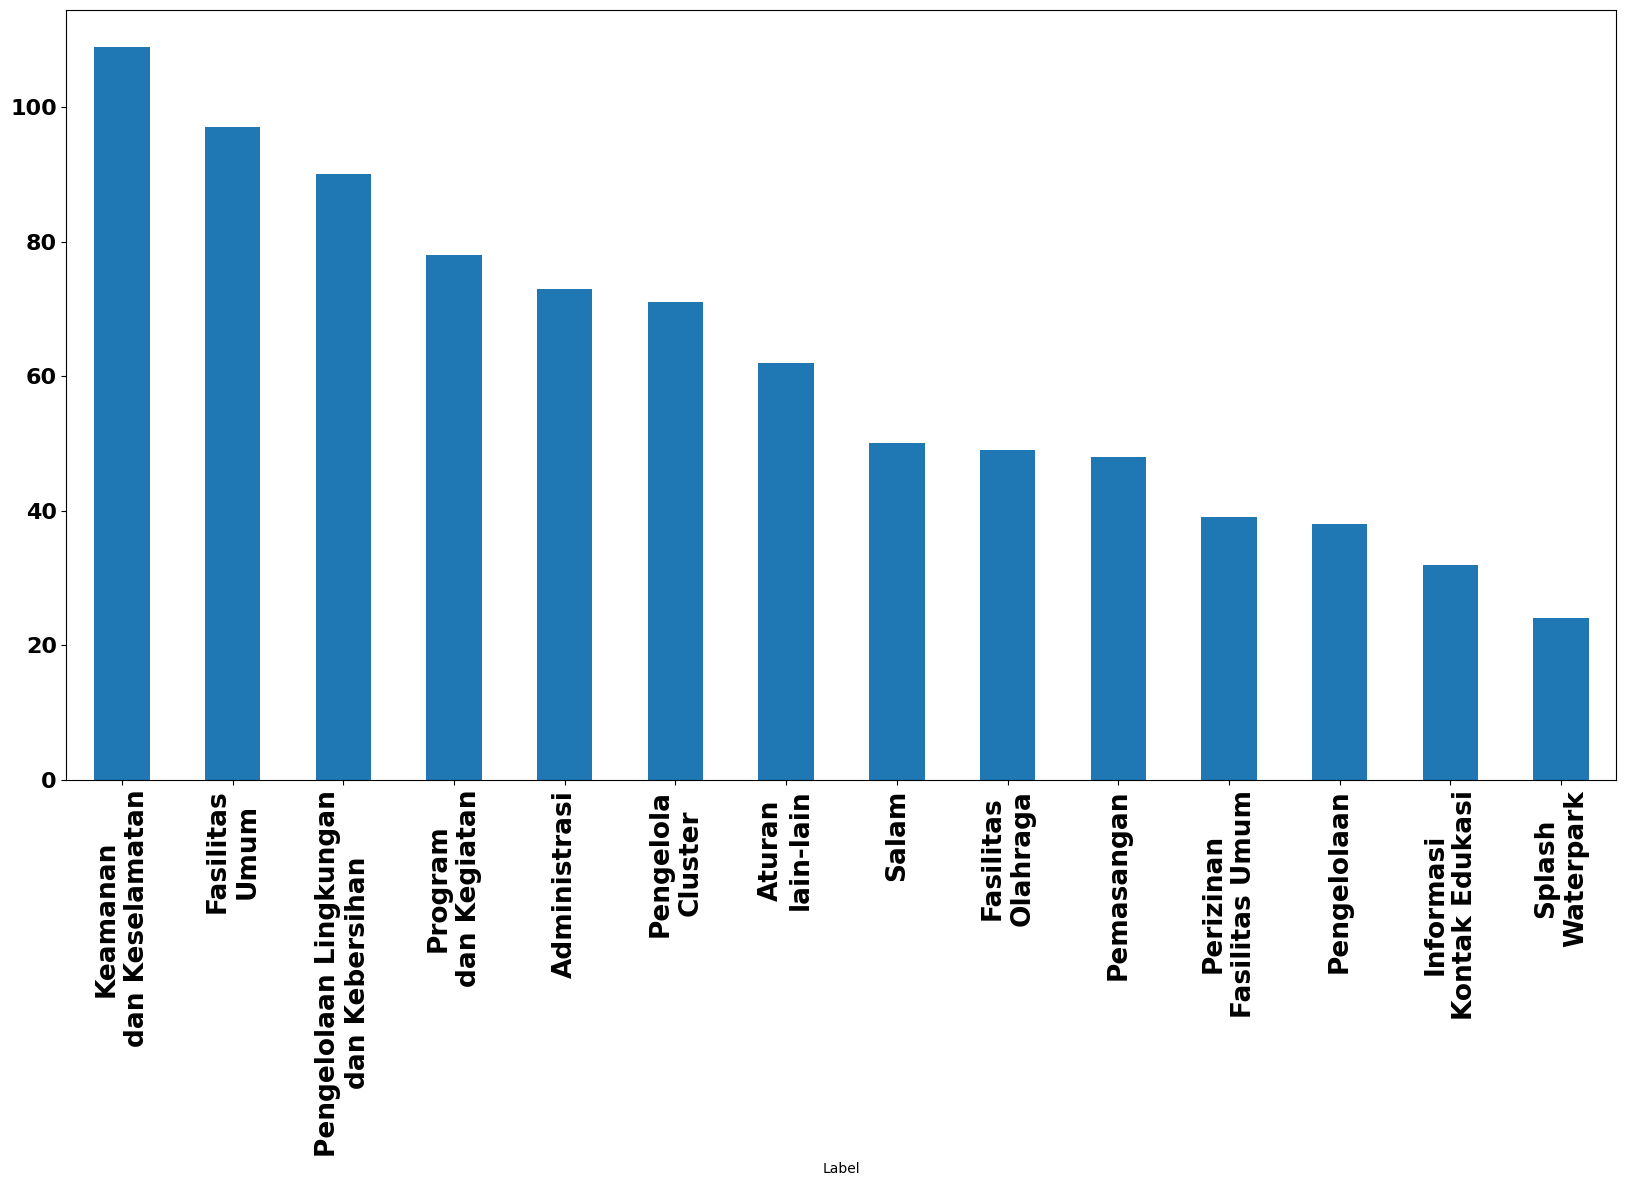

In [ ]:
#penyebaran label

fig , ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
fig = data["Label"].value_counts().plot.bar(ax)

def split_label(label):
    words = label.split()
    if len(words) > 1:
        midpoint = len(words) // 2
        return '\n'.join([' '.join(words[:midpoint]), ' '.join(words[midpoint:])])
    else:
        return label

labels = [split_label(label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, fontsize=19, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16, fontweight='bold')

TypeError: can only concatenate str (not "float") to str

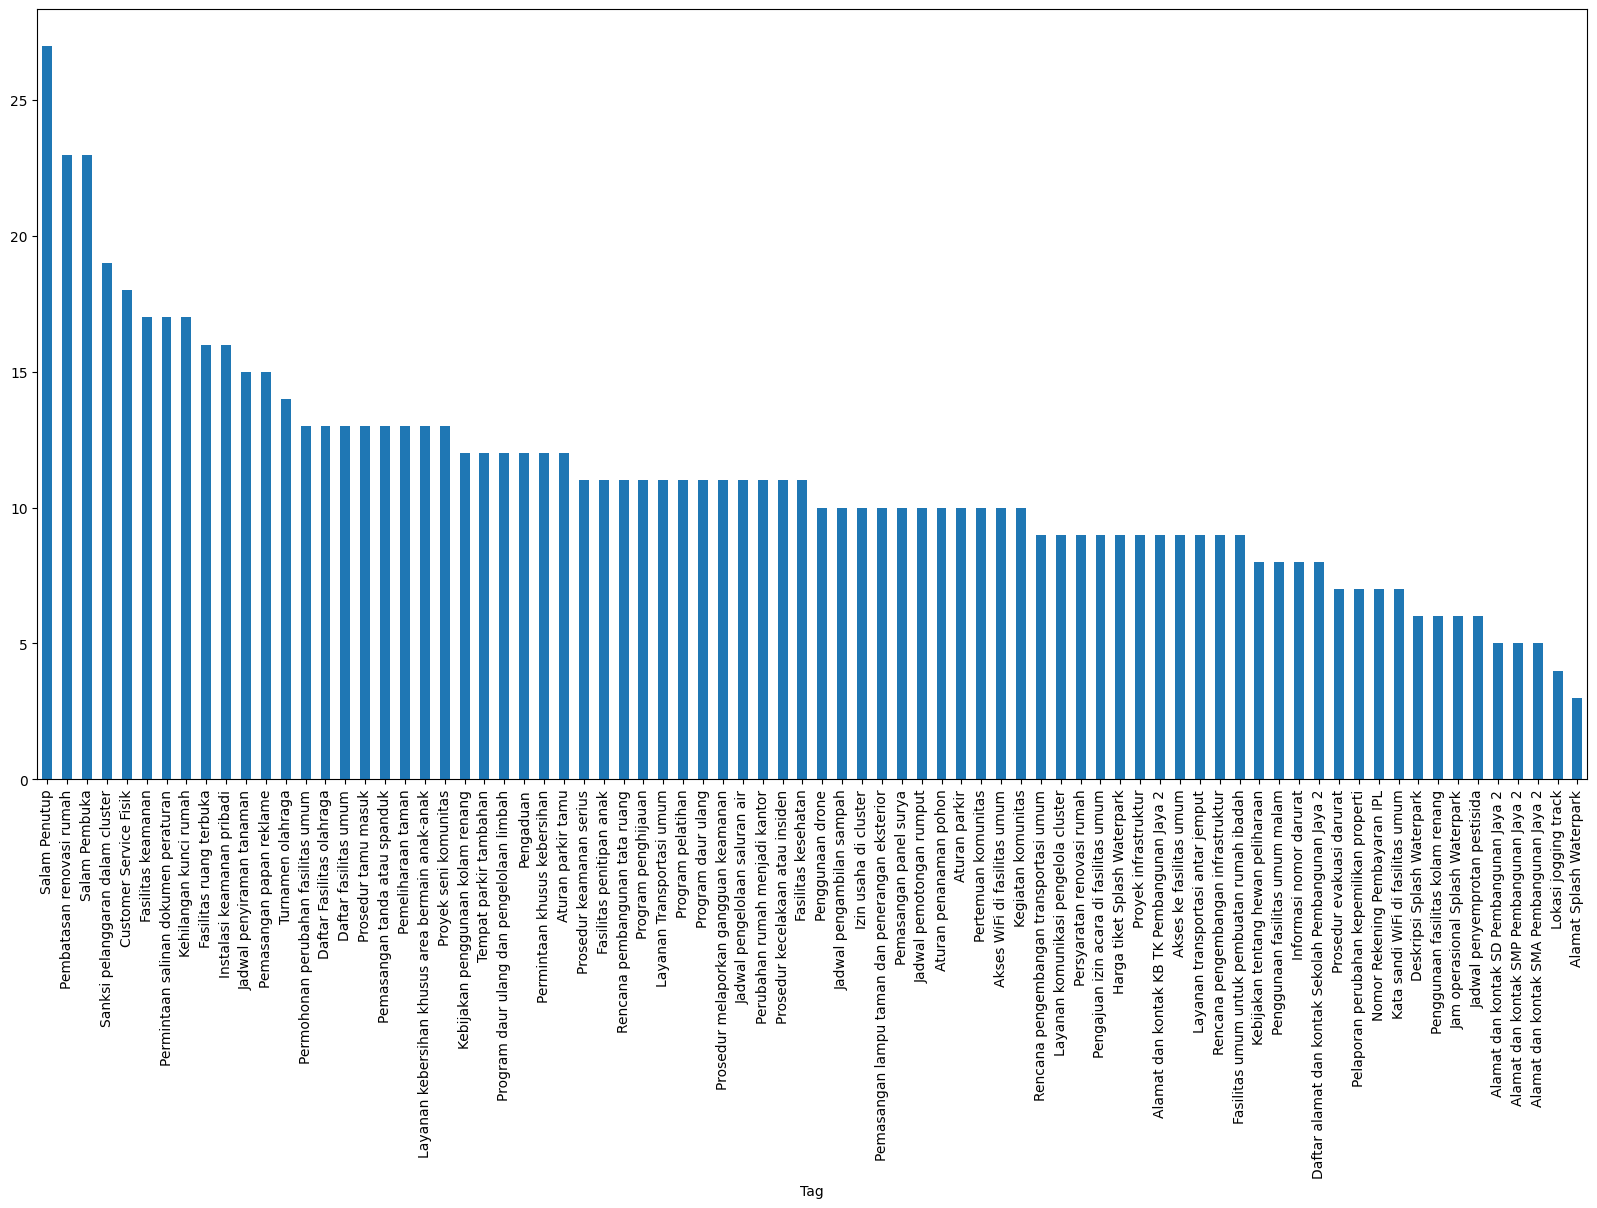

In [ ]:
#penyebaran tag

fig , ax = plt.subplots(1,1)
fig.set_size_inches(20,10)
s = data["Tag"].value_counts()
fig = s.plot.bar(ax)
for i, v in s.reset_index().iterrows():
    fig.text(i, v.Tag + 0.1, str(v.Tag), color='black')

## one hot encoding

In [ ]:
#unique label

label_u = pd.unique(label)
label_u = label_u.tolist()

labels = dict()
for i in range(len(label_u)) :
    labels[i] = label_u[i]
labels

{0: 'Salam',
 1: 'Perizinan Fasilitas Umum',
 2: 'Administrasi',
 3: 'Fasilitas Umum',
 4: 'Splash Waterpark',
 5: 'Informasi Kontak Edukasi',
 6: 'Fasilitas Olahraga',
 7: 'Aturan lain-lain',
 8: 'Program dan Kegiatan',
 9: 'Pengelola Cluster',
 10: 'Keamanan dan Keselamatan',
 11: 'Pengelolaan Lingkungan dan Kebersihan',
 12: 'Pengelolaan',
 13: 'Pemasangan'}

In [ ]:
cls = []
kategori_u = pd.unique(tag)
kategori_u = kategori_u.tolist()
for i in range(len(tag)):
    one_hot = np.zeros((len(kategori_u),), dtype=int)
    idx = kategori_u.index(tag[i])
    one_hot[idx] = 1
    cls.append(one_hot)
cls = np.array(cls)

In [ ]:
tags = dict()
for i in range(len(kategori_u)) :
    tags[i] = kategori_u[i]
tags

{0: 'Salam Pembuka',
 1: 'Fasilitas umum untuk pembuatan rumah ibadah',
 2: 'Perubahan rumah menjadi kantor',
 3: 'Daftar fasilitas umum',
 4: 'Deskripsi Splash Waterpark',
 5: 'Alamat Splash Waterpark',
 6: 'Jam operasional Splash Waterpark',
 7: 'Harga tiket Splash Waterpark',
 8: 'Daftar alamat dan kontak Sekolah Pembangunan Jaya 2',
 9: 'Alamat dan kontak KB TK Pembangunan Jaya 2',
 10: 'Alamat dan kontak SD Pembangunan Jaya 2',
 11: 'Alamat dan kontak SMP Pembangunan Jaya 2',
 12: 'Alamat dan kontak SMA Pembangunan Jaya 2',
 13: 'Lokasi jogging track',
 14: 'Aturan parkir',
 15: 'Kegiatan komunitas',
 16: 'Akses WiFi di fasilitas umum',
 17: 'Kata sandi WiFi di fasilitas umum',
 18: 'Layanan komunikasi pengelola cluster',
 19: 'Fasilitas keamanan',
 20: 'Prosedur melaporkan gangguan keamanan',
 21: 'Kebijakan tentang hewan peliharaan',
 22: 'Pengajuan izin acara di fasilitas umum',
 23: 'Pembatasan renovasi rumah',
 24: 'Akses ke fasilitas umum',
 25: 'Sanksi pelanggaran dalam clu

In [ ]:
import pickle
f = open('tags.pickle', 'wb')
pickle.dump(tags, f)
f.close()

In [ ]:
print(isi.shape)
print(cls.shape)

(860,)
(860, 78)


## preprocessing

### remove punctuation & tokenization

In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

cleaned_text = []
for i in isi :
    cleaned_text.append(remove_punct(str(i)))
cleaned_text

['Selamat pagi',
 'Halo',
 'Assalamualaikum',
 'Salam sejahtera',
 'Selamat siang',
 'Selamat sore',
 'Selamat malam',
 'Hai',
 'Yo',
 'Hei',
 'Permisi',
 'Misi',
 'cs puri surya jaya bukan',
 'bisa tanya',
 'benar dengan customer service puri surya jaya',
 'halo selamat pagi',
 'halo selamat siang',
 'halo selamat sore',
 'halo selamat malam',
 'Hai selamat pagi',
 'Hai selamat siang',
 'Hai selamat sore',
 'Hai selamat malam',
 'Apakah fasilitas umum boleh dimanfaatkan untuk pembuatan rumah ibadah ',
 'Apakah dimungkinkan untuk menggunakan fasilitas umum dalam proses pembangunan rumah ibadah',
 'Bisakah infrastruktur publik dimanfaatkan dalam pembuatan tempat ibadah',
 'Apakah izin menggunakan fasilitas umum dapat diberikan untuk pembangunan rumah ibadah',
 'Apakah ada regulasi yang mengizinkan pemanfaatan fasilitas umum untuk pembangunan rumah ibadah',
 'Apakah Cluster Puri Surya Jaya memiliki kebijakan terkait penggunaan fasilitas umum untuk pembuatan rumah ibadah',
 'Bagaimana keb

In [ ]:
tokens = []
for i in cleaned_text :
    sen = i.split()
    tokens.append(sen)
tokens

[['Selamat', 'pagi'],
 ['Halo'],
 ['Assalamualaikum'],
 ['Salam', 'sejahtera'],
 ['Selamat', 'siang'],
 ['Selamat', 'sore'],
 ['Selamat', 'malam'],
 ['Hai'],
 ['Yo'],
 ['Hei'],
 ['Permisi'],
 ['Misi'],
 ['cs', 'puri', 'surya', 'jaya', 'bukan'],
 ['bisa', 'tanya'],
 ['benar', 'dengan', 'customer', 'service', 'puri', 'surya', 'jaya'],
 ['halo', 'selamat', 'pagi'],
 ['halo', 'selamat', 'siang'],
 ['halo', 'selamat', 'sore'],
 ['halo', 'selamat', 'malam'],
 ['Hai', 'selamat', 'pagi'],
 ['Hai', 'selamat', 'siang'],
 ['Hai', 'selamat', 'sore'],
 ['Hai', 'selamat', 'malam'],
 ['Apakah',
  'fasilitas',
  'umum',
  'boleh',
  'dimanfaatkan',
  'untuk',
  'pembuatan',
  'rumah',
  'ibadah'],
 ['Apakah',
  'dimungkinkan',
  'untuk',
  'menggunakan',
  'fasilitas',
  'umum',
  'dalam',
  'proses',
  'pembangunan',
  'rumah',
  'ibadah'],
 ['Bisakah',
  'infrastruktur',
  'publik',
  'dimanfaatkan',
  'dalam',
  'pembuatan',
  'tempat',
  'ibadah'],
 ['Apakah',
  'izin',
  'menggunakan',
  'fasilit

### lowercasing

In [ ]:
def lower_token(tokens):
    return [w.lower() for w in tokens]

lower_tokens = [lower_token(token) for token in tokens]

lower = [' '.join(sen) for sen in lower_tokens]
lower

['selamat pagi',
 'halo',
 'assalamualaikum',
 'salam sejahtera',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'hai',
 'yo',
 'hei',
 'permisi',
 'misi',
 'cs puri surya jaya bukan',
 'bisa tanya',
 'benar dengan customer service puri surya jaya',
 'halo selamat pagi',
 'halo selamat siang',
 'halo selamat sore',
 'halo selamat malam',
 'hai selamat pagi',
 'hai selamat siang',
 'hai selamat sore',
 'hai selamat malam',
 'apakah fasilitas umum boleh dimanfaatkan untuk pembuatan rumah ibadah',
 'apakah dimungkinkan untuk menggunakan fasilitas umum dalam proses pembangunan rumah ibadah',
 'bisakah infrastruktur publik dimanfaatkan dalam pembuatan tempat ibadah',
 'apakah izin menggunakan fasilitas umum dapat diberikan untuk pembangunan rumah ibadah',
 'apakah ada regulasi yang mengizinkan pemanfaatan fasilitas umum untuk pembangunan rumah ibadah',
 'apakah cluster puri surya jaya memiliki kebijakan terkait penggunaan fasilitas umum untuk pembuatan rumah ibadah',
 'bagaimana kebi

### stop words removal

In [ ]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def stopwords_remover(tokens):
    tokens = [stopword.remove(text) for text in tokens]
    return tokens

res_stpw = stopwords_remover(lower)
res_stpw

['selamat pagi',
 '',
 'assalamualaikum',
 'sejahtera',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 '',
 'yo',
 'hei',
 'permisi',
 'misi',
 'cs puri surya jaya',
 '',
 'customer service puri surya jaya',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'fasilitas umum dimanfaatkan pembuatan rumah ibadah',
 'fasilitas umum proses pembangunan rumah ibadah',
 'infrastruktur publik dimanfaatkan pembuatan ibadah',
 'izin fasilitas umum pembangunan rumah ibadah',
 'regulasi mengizinkan pemanfaatan fasilitas umum pembangunan rumah ibadah',
 'cluster puri surya jaya memiliki kebijakan terkait penggunaan fasilitas umum pembuatan rumah ibadah',
 'kebijakan cluster puri surya jaya terkait izin penggunaan fasilitas umum keperluan rumah ibadah',
 'cluster puri surya jaya mengatur persetujuan pembuatan rumah ibadah fasilitas umum persentase persetujuan',
 'koordinasi penghuni manajemen cluster kont

### stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem(text) :
    text = stemmer.stem(text)
    return text

result_stemmed = [stem(sen) for sen in res_stpw]
result_stemmed

['selamat pagi',
 '',
 'assalamualaikum',
 'sejahtera',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 '',
 'yo',
 'hei',
 'permisi',
 'misi',
 'cs puri surya jaya',
 '',
 'customer service puri surya jaya',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'fasilitas umum manfaat buat rumah ibadah',
 'fasilitas umum proses bangun rumah ibadah',
 'infrastruktur publik manfaat buat ibadah',
 'izin fasilitas umum bangun rumah ibadah',
 'regulasi izin manfaat fasilitas umum bangun rumah ibadah',
 'cluster puri surya jaya milik bijak kait guna fasilitas umum buat rumah ibadah',
 'bijak cluster puri surya jaya kait izin guna fasilitas umum perlu rumah ibadah',
 'cluster puri surya jaya atur tuju buat rumah ibadah fasilitas umum persentase tuju',
 'koordinasi huni manajemen cluster konteks tuju buat rumah ibadah fasilitas umum',
 'rumah huni jadi kantor',
 'ubah rumah tinggal kantor',
 'rumah hu

### slang word converting

In [ ]:
#make slang dictionary

url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv"
response = requests.get(url)
csv_data = response.text

slang_dict = {}

reader = csv.reader(StringIO(csv_data))
for row in reader:
    if len(row) >= 2:
        slang_dict[row[0]] = row[1]

slang_dict

{'slang': 'formal',
 'woww': 'wow',
 'aminn': 'amin',
 'met': 'selamat',
 'netaas': 'menetas',
 'keberpa': 'keberapa',
 'eeeehhhh': 'eh',
 'kata2nyaaa': 'kata-katanya',
 'hallo': 'halo',
 'kaka': 'kakak',
 'ka': 'kak',
 'daah': 'dah',
 'aaaaahhhh': 'ah',
 'yaa': 'ya',
 'smga': 'semoga',
 'slalu': 'selalu',
 'amiin': 'amin',
 'kk': 'kakak',
 'trus': 'terus',
 'sii': 'sih',
 'nyenengin': 'menyenangkan',
 'bgt': 'banget',
 'gemess': 'gemas',
 'akuuu': 'aku',
 'jgn': 'jangan',
 'udah': 'sudah',
 'gitu': 'begitu',
 'aja': 'saja',
 'gemesiin': 'menggemaskan',
 'menyenangkn': 'menyenangkan',
 'rb': 'ribu',
 'akau': 'aku',
 'saranin': 'menyarankan',
 'nemuin': 'menemukan',
 'yah': 'ya',
 'mnis2nya': 'manis-manisnya',
 'gtu': 'begitu',
 'tu': 'itu',
 'idolaa': 'idola',
 'bangett': 'banget',
 'kaakk': 'kak',
 'baaiikkk': 'baik',
 'telaatt': 'telat',
 'kaak': 'kak',
 'yg': 'yang',
 'lg': 'lagi',
 'skarang': 'sekarang',
 'sempet': 'sempat',
 'karna': 'karena',
 'ngga': 'enggak',
 'mantep': 'mantap

In [ ]:
f = open('slangs.pickle', 'wb')
pickle.dump(slang_dict, f)
f.close()

In [ ]:
def replace_all(mylist, slang_dict):
    for i, j in slang_dict.items():
        for index, sentence in enumerate(mylist):
            words = sentence.split()
            if i in words:
                word_index = words.index(i)
                words[word_index] = j
                mylist[index] = ' '.join(words)
    return mylist

no_slang = replace_all(result_stemmed, slang_dict)
no_slang

['selamat pagi',
 '',
 'assalamualaikum',
 'sejahtera',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 '',
 'ya',
 'hei',
 'permisi',
 'misi',
 'cs puri surya jaya',
 '',
 'customer service puri surya jaya',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'selamat pagi',
 'selamat siang',
 'selamat sore',
 'selamat malam',
 'fasilitas umum manfaat buat rumah ibadah',
 'fasilitas umum proses bangun rumah ibadah',
 'infrastruktur publik manfaat buat ibadah',
 'izin fasilitas umum bangun rumah ibadah',
 'regulasi izin manfaat fasilitas umum bangun rumah ibadah',
 'cluster puri surya jaya milik bijak kait guna fasilitas umum buat rumah ibadah',
 'bijak cluster puri surya jaya kait izin guna fasilitas umum perlu rumah ibadah',
 'cluster puri surya jaya atur tuju buat rumah ibadah fasilitas umum persentase tuju',
 'koordinasi huni manajemen cluster konteks tuju buat rumah ibadah fasilitas umum',
 'rumah huni jadi kantor',
 'ubah rumah tinggal kantor',
 'rumah hu

### bag of words

In [ ]:
tokens = []
for i in no_slang :
    token = i.split()
    tokens.append(token)
tokens

[['selamat', 'pagi'],
 [],
 ['assalamualaikum'],
 ['sejahtera'],
 ['selamat', 'siang'],
 ['selamat', 'sore'],
 ['selamat', 'malam'],
 [],
 ['ya'],
 ['hei'],
 ['permisi'],
 ['misi'],
 ['cs', 'puri', 'surya', 'jaya'],
 [],
 ['customer', 'service', 'puri', 'surya', 'jaya'],
 ['selamat', 'pagi'],
 ['selamat', 'siang'],
 ['selamat', 'sore'],
 ['selamat', 'malam'],
 ['selamat', 'pagi'],
 ['selamat', 'siang'],
 ['selamat', 'sore'],
 ['selamat', 'malam'],
 ['fasilitas', 'umum', 'manfaat', 'buat', 'rumah', 'ibadah'],
 ['fasilitas', 'umum', 'proses', 'bangun', 'rumah', 'ibadah'],
 ['infrastruktur', 'publik', 'manfaat', 'buat', 'ibadah'],
 ['izin', 'fasilitas', 'umum', 'bangun', 'rumah', 'ibadah'],
 ['regulasi',
  'izin',
  'manfaat',
  'fasilitas',
  'umum',
  'bangun',
  'rumah',
  'ibadah'],
 ['cluster',
  'puri',
  'surya',
  'jaya',
  'milik',
  'bijak',
  'kait',
  'guna',
  'fasilitas',
  'umum',
  'buat',
  'rumah',
  'ibadah'],
 ['bijak',
  'cluster',
  'puri',
  'surya',
  'jaya',
  'ka

In [ ]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(tokens)
train = tokenizer.texts_to_sequences(tokens)
train

[[107, 250],
 [],
 [366],
 [367],
 [107, 226],
 [107, 251],
 [107, 108],
 [],
 [368],
 [369],
 [370],
 [371],
 [372, 4, 3, 2],
 [],
 [180, 181, 4, 3, 2],
 [107, 250],
 [107, 226],
 [107, 251],
 [107, 108],
 [107, 250],
 [107, 226],
 [107, 251],
 [107, 108],
 [5, 6, 157, 201, 8, 133],
 [5, 6, 68, 20, 8, 133],
 [81, 158, 157, 201, 133],
 [11, 5, 6, 20, 8, 133],
 [134, 11, 157, 5, 6, 20, 8, 133],
 [1, 4, 3, 2, 28, 35, 9, 32, 5, 6, 201, 8, 133],
 [35, 1, 4, 3, 2, 9, 11, 32, 5, 6, 373, 8, 133],
 [1, 4, 3, 2, 7, 135, 201, 8, 133, 5, 6, 374, 135],
 [298, 13, 227, 1, 375, 135, 201, 8, 133, 5, 6],
 [8, 13, 109, 73],
 [36, 8, 115, 73],
 [8, 13, 73],
 [11, 36, 8, 73],
 [17, 7, 9, 109, 8, 73],
 [58, 376, 11, 32, 8, 73],
 [35, 1, 4, 3, 2, 9, 36, 8, 13, 73],
 [7, 7, 32, 8, 13, 73, 1, 4, 3, 2],
 [1, 4, 3, 2, 41, 36, 8, 13, 73],
 [299, 377, 8, 13, 36, 73, 1, 4, 3, 2],
 [252, 182, 36, 8, 13, 73, 116, 1, 4, 3, 2],
 [5, 6, 16, 1, 4, 3, 2],
 [5, 158, 48, 25, 1, 4, 3, 2],
 [253, 254, 6, 1, 4, 3, 2],
 [5, 1

In [ ]:
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 574 unique tokens.


## word embedding

In [ ]:
MAX_SEQUENCE_LENGTH = 20
embedding_dim = 300
X = pad_sequences(train, maxlen=MAX_SEQUENCE_LENGTH)
print(X)

[[  0   0   0 ...   0 107 250]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 366]
 ...
 [  0   0   0 ... 161 164 362]
 [  0   0   0 ... 574  14  16]
 [  0   0   0 ... 124  39  14]]


In [ ]:
f = open('tokenizer_cv_lstm.pickle', 'wb')
pickle.dump(tokenizer, f)
f.close()

In [ ]:
vocab_size = len(train_word_index) + 1
train_embedding_weights = np.zeros((vocab_size, embedding_dim))

for word, index in train_word_index.items():
    train_embedding_weights[index] = np.random.rand(embedding_dim)

embedding_layer = nn.Embedding(vocab_size, embedding_dim)
embedding_layer.weight.data.copy_(torch.tensor(train_embedding_weights))
embedding_layer.weight.requires_grad = False

print(embedding_layer.weight.shape)

torch.Size([575, 300])


In [ ]:
weight_numpy = embedding_layer.weight.detach().numpy()
keras_embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                  output_dim=embedding_dim,
                                                  weights=[weight_numpy])

## data training

### lstm

In [ ]:
model = Sequential()
model.add(keras_embedding_layer)
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(LSTM(78))
model.add(Dropout(0.5))
model.add(Dense(78, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         172500    
                                                                 
 dense (Dense)               (None, None, 128)         38528     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm (LSTM)                 (None, 78)                64584     
                                                                 
 dropout_1 (Dropout)         (None, 78)                0         
                                                                 
 dense_1 (Dense)             (None, 78)                6162      
                                                                 
Total params: 281774 (1.07 MB)
Trainable params: 281774 

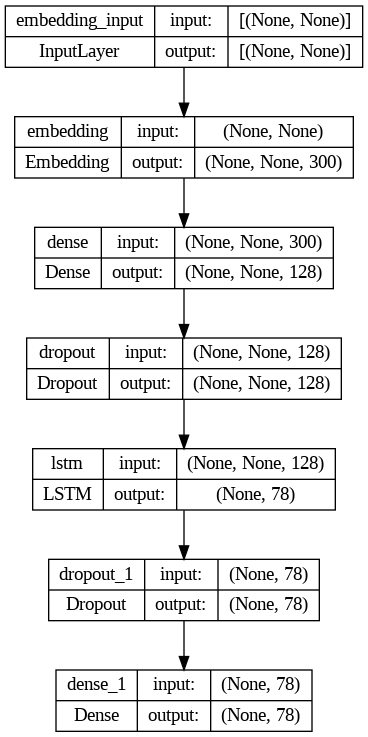

In [ ]:
plot_model(model, to_file='model_lstmtb.png', show_shapes=True, show_layer_names=True, rankdir="TB")

In [ ]:
X = np.array(X)
y = cls

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,  61,  11, 210],
       [  0,   0,   0, ...,   1,  28, 264],
       ...,
       [  0,   0,   0, ...,  46,  90,  62],
       [  0,   0,   0, ...,  33,  65,   1],
       [  0,   0,   0, ...,  20,   2,  34]], dtype=int32)

In [ ]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
num_epochs = 250
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20)
model_save = ModelCheckpoint('model_lstm.hdf5', save_best_only= True, verbose=0)

In [ ]:
hist = model.fit(X_train, y_train, epochs=num_epochs, shuffle=True,
                 validation_data=(X_test, y_test), batch_size=batch_size,
                 callbacks=[model_save])

Epoch 1/250
22/22 [==============================] - ETA: 0s - loss: 4.3928 - acc: 0.0102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 12s 169ms/step - loss: 4.3928 - acc: 0.0102 - val_loss: 4.3264 - val_acc: 0.0174
Epoch 2/250
22/22 [==============================] - 1s 29ms/step - loss: 4.3213 - acc: 0.0233 - val_loss: 4.3188 - val_acc: 0.0116
Epoch 3/250
22/22 [==============================] - 1s 30ms/step - loss: 4.2816 - acc: 0.0276 - val_loss: 4.2429 - val_acc: 0.0698
Epoch 4/250
22/22 [==============================] - 1s 29ms/step - loss: 4.1861 - acc: 0.0683 - val_loss: 4.2015 - val_acc: 0.0465
Epoch 5/250
22/22 [==============================] - 1s 30ms/step - loss: 4.0741 - acc: 0.0683 - val_loss: 4.0808 - val_acc: 0.0640
Epoch 6/250
22/22 [==============================] - 1s 30ms/step - loss: 4.0079 - acc: 0.0698 - val_loss: 3.9865 - val_acc: 0.1163
Epoch 7/250
22/22 [==============================] - 1s 29ms/step - loss: 3.8076 - acc: 0.1105 - val_loss: 3.8482 - val_acc: 0.1570
Epoch 8/250
22/22 [==============================] - 1s 28ms/step - loss: 3.7148 - acc

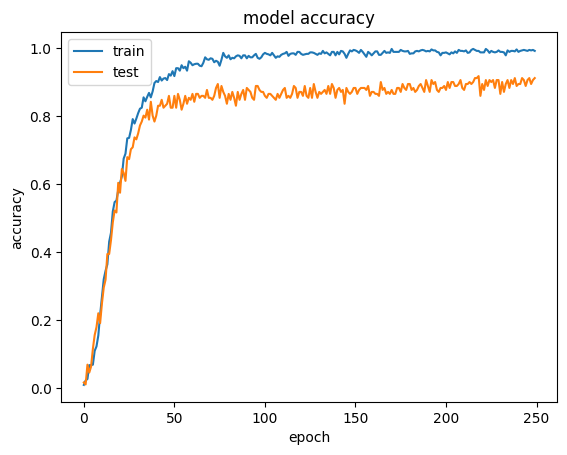

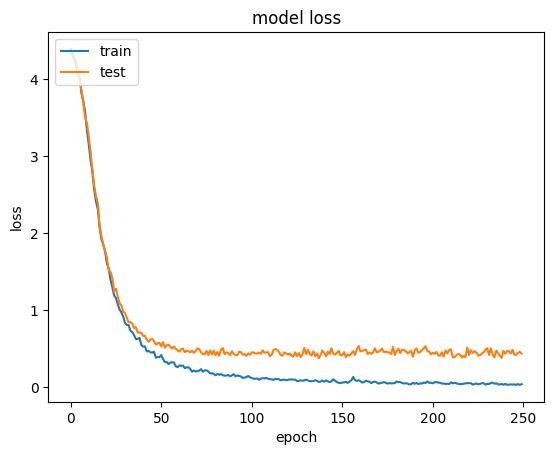

In [ ]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Average Train Accuracy: 0.9063430302478374
Average Test Accuracy: 0.8146976749971508
Average Train Loss: 0.42732515005022287
Average Test Loss: 0.7218900241851807


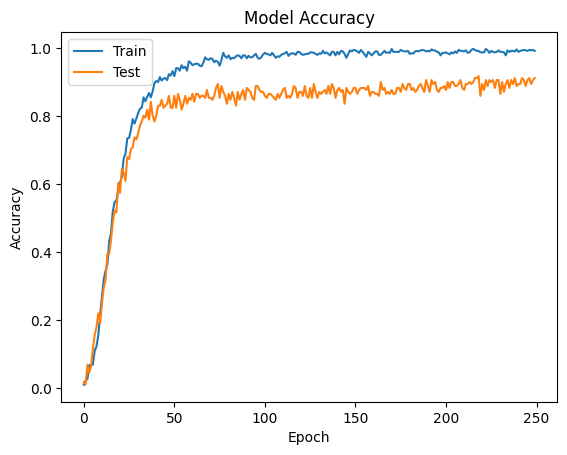

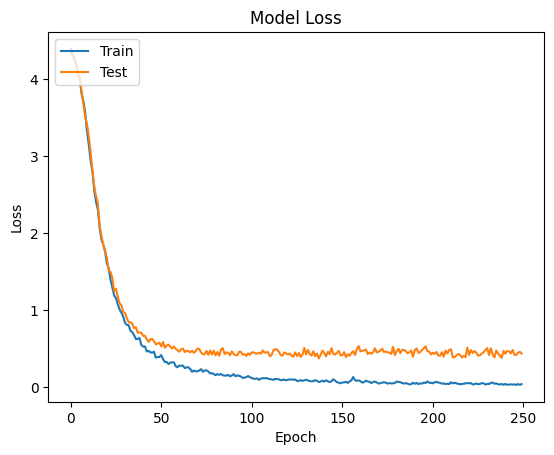

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have trained your model and stored the history in 'hist'

# Calculate average values
train_acc_avg = np.mean(hist.history['acc'])
val_acc_avg = np.mean(hist.history['val_acc'])
train_loss_avg = np.mean(hist.history['loss'])
val_loss_avg = np.mean(hist.history['val_loss'])

# Print average values
print("Average Train Accuracy:", train_acc_avg)
print("Average Test Accuracy:", val_acc_avg)
print("Average Train Loss:", train_loss_avg)
print("Average Test Loss:", val_loss_avg)

# Plot model accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot model loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#eval
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 8ms/step - loss: 0.4333 - acc: 0.9128


[0.4333384335041046, 0.9127907156944275]

## report

In [ ]:
from sklearn.metrics import classification_report

test_predictions = model.predict(X_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(y_test, axis=1)

report = classification_report(test_true_labels, test_predicted_labels)

print(report)

6/6 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          16       1.00      0.67      0.80         3
          17       0.00      0.00      0.00         0
          19       1.00      1.00      1.00         2
          20       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## interact

### lstm

In [ ]:
import numpy as np
import pickle
from keras.models import load_model
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

factory = StemmerFactory()
stemmer = factory.create_stemmer()

with open('tokenizer_cv_lstm.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

model = load_model('model_lstm.hdf5')

def preprocess_input(text):
    text_nopunct = remove_punct(text)
    text_lower = text_nopunct.lower()
    text_tokenized = text_lower.split()
    text_stopwords_removed = stopwords_remover(text_tokenized)
    text_stemmed = [stemmer.stem(word) for word in text_stopwords_removed]
    return ' '.join(text_stemmed)

def generate_response(input_text):
    preprocessed_input = preprocess_input(input_text)
    input_sequence = tokenizer.texts_to_sequences([preprocessed_input])
    padded_sequence = pad_sequences(input_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    predicted_probs = model.predict(padded_sequence)[0]
    predicted_index = np.argmax(predicted_probs)
    predicted_tag = tags[predicted_index]

    tag_index = np.where(tags_index == predicted_tag)[0]
    if len(tag_index) > 0:
        # Retrieve the corresponding answer from the answers array
        answer = answers[tag_index[0]]
        return answer

print("Chatbot: Hi! How can I help you today?")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        print("Chatbot: Goodbye!")
        break

    bot_response = generate_response(user_input)
    print("Chatbot:", bot_response)

Chatbot: Hi! How can I help you today?
1/1 [==============================] - 1s 710ms/step


<ipython-input-112-583d364bd766>:34: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  tag_index = np.where(tags_index == predicted_tag)[0]


Chatbot: None
1/1 [==============================] - 0s 24ms/step
Chatbot: None
Chatbot: Goodbye!
